## Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import json
import nltk
import contractions
import re
from sklearn.model_selection import train_test_split
from collections import Counter
import pydotplus
from sklearn import tree
from IPython.display import Image
import string
from scipy.sparse import csr_matrix
import warnings
import textblob
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score,classification_report, confusion_matrix,
    f1_score, make_scorer, roc_curve, roc_auc_score, precision_score, recall_score)
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import sklearn.cluster as cluster
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from xgboost import XGBClassifier
from sklearn.model_selection import (cross_val_score, cross_validate, train_test_split,
    GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold)
import shap
from shap import TreeExplainer
warnings.filterwarnings("ignore")

## Functions definitions

In [2]:
#Function to return  Models recap
def get_metrics_clf(y_test, y_probs, th=0.5, name_col='model'):
    perf = pd.DataFrame(
        [   th,
            np.round(precision_score(y_test, (y_probs > th), pos_label=0), 3),
            np.round(recall_score(y_test, (y_probs > th), pos_label=0), 3),
            np.round(f1_score(y_test, (y_probs > th), pos_label=0), 3),
            np.round(accuracy_score(y_test, (y_probs > th)), 3),
            np.round(roc_auc_score(y_test, y_probs), 3)
        ],
        index=['Threshold','Precision', 'Recall', 'F1', 'Accuracy', 'AUC'],
        columns=[name_col]
    )

    return perf

In [3]:
#Returns a plot with the ROC corves of all models
def get_roc_curve_plot_new(y_test, y_probs, legend_model='Model', multiple=False):
    color_line = ['skyblue', 'green', 'orange', 'purple', 'pink']
    plt.style.use('default')
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)

    # plot the roc curve for the model
    if not multiple:
        if type(y_probs[0]) == pd.core.series.Series:
            return print("If you want to display more prediction at the same time you have to set parameter 'multiple=True'")
        else:
            m_fpr, m_tpr, _ = roc_curve(y_test, y_probs)
            plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill', color='red', linewidth=0.75)
            plt.plot(m_fpr, m_tpr, label=legend_model, color=color_line[0], linewidth=0.75)      
    else:
        plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill', color='red', linewidth=0.75)
        for i in range(len(y_probs)):
            m_fpr, m_tpr, _ = roc_curve(y_test, y_probs[i])
            plt.plot(m_fpr, m_tpr, label=legend_model[i], color=color_line[i], linewidth=0.75)

    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.legend(loc=4)
    plt.rcParams["figure.figsize"] = (10, 10)
    plt.show()

In [4]:
def report_cv(results, n_top=7):
    '''Report of cross validation results.'''
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Mean validation score: {0:.5f} (std: {1:.5f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}\n".format(results['params'][candidate]))

In [5]:
#With this function I extract the cluster and compute the lda on it
def extractclusterlda(df,col,cluster):
    newdf=pd.DataFrame(df[df[col]==cluster])
    newdf.drop([col],axis=1,inplace=True)
    matrix=csr_matrix(newdf.values)
    n_components=1
    lda=LatentDirichletAllocation(n_components=n_components, max_iter=10,
                                learning_method = 'batch',
                                n_jobs=-1)#,verbose=1
    lda=lda.fit(matrix)
    return lda

In [6]:
#Function to apply on a single cluster for a single topic
def print_main_topic(model, feature_names, n_top_words,topic_idx):
    for topic in model.components_:
        message = f'{topic_idx}: '
        message += ', '.join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        return message   

In [7]:
#Function to apply with n topics to find
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f'Topic {topic_idx}: '
        message += ', '.join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()    

In [8]:
#Function for obtain feature importance from Random Forest
def print_feature_importances_random_forest(random_forest_model):
    
    '''
    Prints the feature importances of a Random Forest model in an ordered way.
    random_forest_model -> The sklearn.ensemble.RandomForestRegressor or RandomForestClassifier trained model
    '''
    
    # Fetch the feature importances and feature names
    importances = random_forest_model.feature_importances_
    features = random_forest_model.feature_names_in_
    
    # Organize them in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}#
    
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f}")

In [9]:
#Function for parse json file so that I can open it as dataframe
def parse_data(file):
    for l in open(file,'r'):
        yield json.loads(l)

## Opening the dataframe and exploration of data

In [10]:
data = list(parse_data('./Sarcasm_Headlines_Dataset.json'))
df = pd.DataFrame(data)

In [11]:
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [12]:
#Dropping article_link
df.drop('article_link', axis=1, inplace=True)
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [13]:
df.shape

(26709, 2)

In [14]:
df['is_sarcastic'].value_counts()

0    14985
1    11724
Name: is_sarcastic, dtype: int64

## Basic NLP Count based Features

In [15]:
df['char_count'] = df['headline'].apply(len)
df['word_count'] = df['headline'].apply(lambda x: len(x.split()))
df['word_density'] = df['char_count'] / (df['word_count']+1)
df['punctuation_count'] = df['headline'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 

In [16]:
df.head()

,headline,is_sarcastic,char_count,word_count,word_density,punctuation_count
0,former versace store clerk sues over secret 'b...,0,78,12,6.000000,2
1,the 'roseanne' revival catches up to our thorn...,0,84,14,5.600000,3
2,mom starting to fear son's web series closest ...,1,79,14,5.266667,1
3,"boehner just wants wife to listen, not come up...",1,84,13,6.000000,2
4,j.k. rowling wishes snape happy birthday in th...,0,64,11,5.333333,2


## Leveraging Text Sentiment

In [17]:
vader = SentimentIntensityAnalyzer()
df['compound'] = [vader.polarity_scores(x)['compound'] for x in df['headline']]
df['neg'] = [vader.polarity_scores(x)['neg'] for x in df['headline']]
df['neu'] = [vader.polarity_scores(x)['neu'] for x in df['headline']]
df['pos'] = [vader.polarity_scores(x)['pos'] for x in df['headline']]
df_snt_obj = df['headline'].apply(lambda row: textblob.TextBlob(row).sentiment)
df['Subjectivity'] = [obj.subjectivity for obj in df_snt_obj.values]

In [18]:
df.head()

,headline,is_sarcastic,char_count,word_count,word_density,punctuation_count,compound,neg,neu,pos,Subjectivity
0,former versace store clerk sues over secret 'b...,0,78,12,6.000000,2,0.0000,0.000,1.000,0.000,0.377778
1,the 'roseanne' revival catches up to our thorn...,0,84,14,5.600000,3,-0.3182,0.272,0.576,0.152,0.400000
2,mom starting to fear son's web series closest ...,1,79,14,5.266667,1,-0.4939,0.198,0.802,0.000,0.100000
3,"boehner just wants wife to listen, not come up...",1,84,13,6.000000,2,0.0000,0.000,1.000,0.000,0.100000
4,j.k. rowling wishes snape happy birthday in th...,0,64,11,5.333333,2,0.6486,0.000,0.629,0.371,0.833333


In [19]:
df.shape

(26709, 11)

## Lemmatization function

In [20]:
#pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz --user

In [21]:
nlp = spacy.load('en_core_web_sm',disable=["parser", "ner"])#parse=False,#tag=False, #entity=False

def spacy_lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

## Text Pre-processing and Wrangling

In [22]:
# remove some stopwords to capture negation in n-grams if possible
stop_words = nltk.corpus.stopwords.words('english')
stop_words.remove('no')
stop_words.remove('not')
stop_words.remove('but')


# load up a simple porter stemmer y
#ps = nltk.porter.PorterStemmer()

def simple_text_preprocessor(document): 
    # lower case
    document = str(document).lower()
    
    # expand contractions
    document = contractions.fix(document)
    
    # remove unnecessary characters
    document = re.sub(r'[^a-zA-Z]',r' ', document)
    document = re.sub(r'nbsp', r'', document)
    document = re.sub(' +', ' ', document)
    
    # lemmatization
    document = ' '.join([spacy_lemmatize_text(word) for word in document.split()])
    
    # stopwords removal
    document = ' '.join([word for word in document.split() if word not in stop_words])
    
    return document

stp = np.vectorize(simple_text_preprocessor)

In [23]:
#It takes quite some time because of lemmatization
df['clean_headline'] = stp(df['headline'].values)

## Data exploration

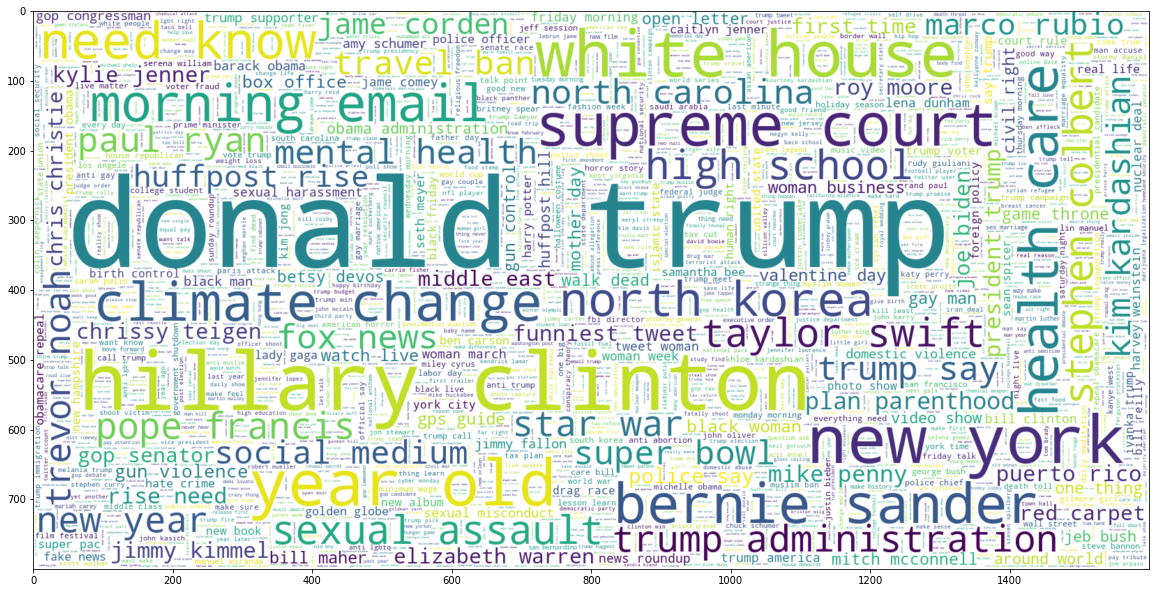

In [24]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 ,background_color='white',min_word_length =3,collocation_threshold=3, width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 0].clean_headline))
plt.imshow(wc , interpolation = 'bilinear')

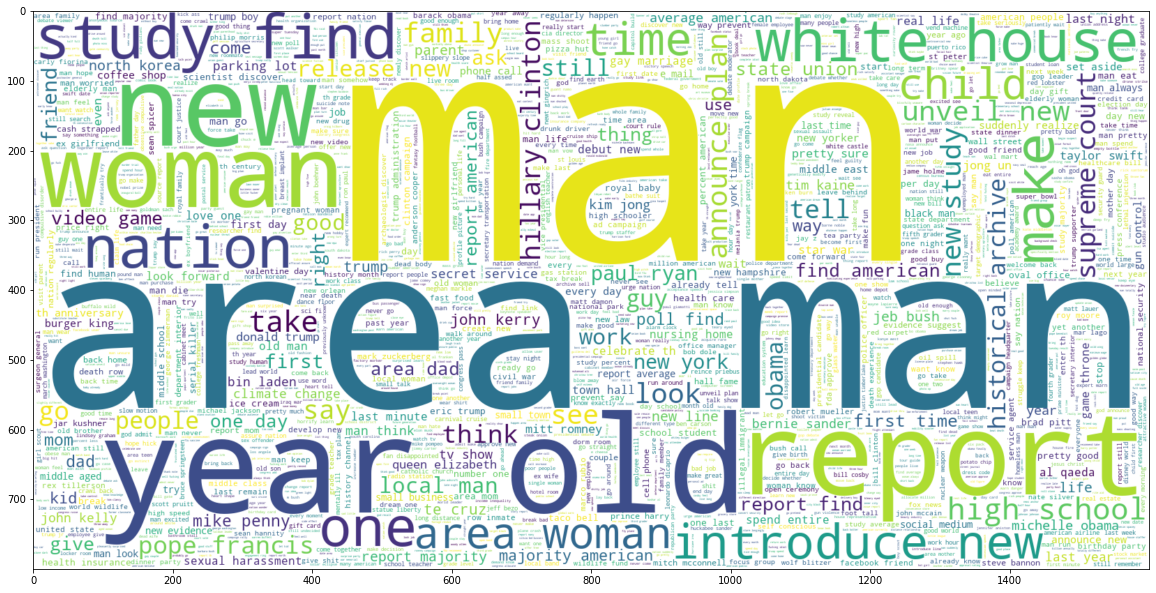

In [25]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 ,background_color='white', collocation_threshold=6, width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 1].clean_headline))#,stopwords=stopwords
plt.imshow(wc , interpolation = 'bilinear')

In [26]:
df.shape

(26709, 12)

In [27]:
#checkpoint
#Creating a copy for the dataset we will use for classification
df2=df.copy()
#dataset on wich run clustering and topic modeling
dfclust=df.copy()

### Splitting whole dataframe on target value

In [28]:
dfclust0=dfclust[dfclust.is_sarcastic == 0]
dfclust1=dfclust[dfclust.is_sarcastic == 1]
print(dfclust0.shape)
dfclust1.shape

(14985, 12)


(11724, 12)

## TF-IDF on df['is_sarcastic']==0

In [29]:
#List of stopwords tuned to obtain the best results after several attempts
stopwords={'area','year','old','report','time','not','get','one','find','take','but','not'
           'find','take','still','go','say','day','first','friend','make'}
#Df on wich run clustering and topic modeling
#Applying some constraints to the tf-idf on the whole df
tv0 = TfidfVectorizer(min_df=5,stop_words=stopwords,ngram_range=(1,2),use_idf=True)#max_df=0.90,stop_words=stopwords,
df_clusttv0 = tv0.fit_transform(dfclust0['clean_headline']).toarray()
df_tv0 = pd.DataFrame(df_clusttv0, columns=tv0.get_feature_names())
df_tv0.shape

(14985, 4256)

## TF-IDF on df['is_sarcastic']==1

In [30]:
#List of stopwords tuned to obtain the best results after several attempts
stopwords={'area','year','old','report','time','not','get','one','find','new','listen'
           'find','take','still','go','say','day','first','friend'}
#Df on wich run clustering and topic modeling
#Applying some constraints to the tf-idf on the whole df
tv = TfidfVectorizer(stop_words=stopwords,min_df=5,ngram_range=(1,2),use_idf=True)
df_clusttv = tv.fit_transform(dfclust1['clean_headline']).toarray()
df_tv = pd.DataFrame(df_clusttv, columns=tv.get_feature_names())
df_tv.shape

(11724, 3620)

## Unsupervised: clustering and topic modeling analysis

## Analysis on is_sarcastic==0

In [31]:
Sum_of_squared_distances= []
K= range(1,11)
for k in K:
    km=KMeans(n_clusters=k,init='k-means++')
    km=km.fit(df_tv0)
    Sum_of_squared_distances.append(km.inertia_)

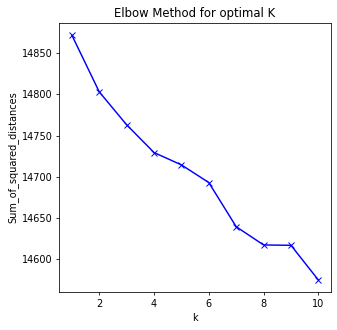

In [32]:
plt.style.use('default')
plt.figure(figsize = (5,5),dpi=70)
plt.plot(K,Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method for optimal K')
plt.show()

In [33]:
km = cluster.KMeans(n_clusters=5, init='k-means++').fit(df_tv0)#

In [34]:
km.cluster_centers_

array([[-1.89735380e-19,  1.62630326e-19, -7.58941521e-19, ...,
        -3.79470760e-19, -1.89735380e-19, -2.71050543e-19],
       [-2.43945489e-19,  4.60785923e-19,  4.30399952e-04, ...,
        -3.25260652e-19,  0.00000000e+00, -1.08420217e-19],
       [ 8.13151629e-20,  0.00000000e+00, -4.33680869e-19, ...,
        -2.71050543e-19,  0.00000000e+00,  1.08420217e-19],
       [ 2.24225129e-04,  2.30187363e-04,  5.56362319e-04, ...,
         3.65250606e-04,  2.43305076e-04,  2.93323798e-04],
       [-3.25260652e-19,  8.13151629e-19, -8.13151629e-19, ...,
         3.53230172e-04,  2.43945489e-19,  4.07095532e-04]])

In [35]:
df_tv0['kmeans_cluster'] = km.labels_
df_tv0['kmeans_cluster'].value_counts()

3    11646
4     1363
1      951
0      774
2      251
Name: kmeans_cluster, dtype: int64

In [37]:
#Extracting the clusters and computing lda on each
lda0=extractclusterlda(df_tv0,'kmeans_cluster',0)
lda1=extractclusterlda(df_tv0,'kmeans_cluster',1)
lda2=extractclusterlda(df_tv0,'kmeans_cluster',2)
lda3=extractclusterlda(df_tv0,'kmeans_cluster',3)
lda4=extractclusterlda(df_tv0,'kmeans_cluster',4)
#Showing results for each topic found in each cluster
models=[lda0,lda1,lda2,lda3,lda4]
topics=['Topic Clust 0','Topic Clust 1','Topic Clust 2','Topic Clust 3','Topic Clust 4']#,'Topic Clust 5'
tf_feature_names = tv0.get_feature_names()
n_top_words=10
for model,topic in zip(models,topics):
    print(print_main_topic(model,tf_feature_names,n_top_words,topic))

Topic Clust 0: new, hillary, hillary clinton, clinton, york, new york, show, trump, book, film
Topic Clust 1: woman, man, world, black, police, cop, black woman, woman business, gay, change
Topic Clust 2: way, good way, change, change way, good, life, new, people, well, pave way
Topic Clust 3: good, thing, need, love, people, life, want, obama, watch, know
Topic Clust 4: trump, donald, donald trump, president, gop, call, ban, would, attack, american


In [38]:
df_tv0.drop(['kmeans_cluster'], axis=1, inplace=True)

In [39]:
tf_feature_names = tv0.get_feature_names()
n_top_words = 10
n_components = 5
lda = LatentDirichletAllocation(n_components=n_components, max_iter=10,
                                learning_method = 'batch',
                                n_jobs=-1)#,verbose=1
lda.fit(df_tv0)
print(print_top_words(lda, tf_feature_names, n_top_words))

Topic 0: trump, donald, donald trump, man, lesson, tweet, like, woman, learn, back
Topic 1: change, know, need, climate, news, never, really, want, way, huffpost
Topic 2: new, world, health, care, thing, good, life, people, book, way
Topic 3: clinton, hillary, hillary clinton, north, right, sander, new, shoot, bernie, trump
Topic 4: new, trump, woman, white, american, house, love, new york, york, live

None


In [40]:
tf_feature_names = tv0.get_feature_names()
n_top_words = 10
n_components = 1
lda = LatentDirichletAllocation(n_components=n_components, max_iter=10,
                                learning_method = 'batch',
                                n_jobs=-1)#,verbose=1
lda.fit(df_tv0)
print(print_main_topic(lda, tf_feature_names, n_top_words,'General topic'))

General topic: trump, new, woman, donald, donald trump, man, good, way, thing, world


## Analysis on is_sarcastic==1

In [41]:
Sum_of_squared_distances= []
K= range(1,11)
for k in K:
    km=KMeans(n_clusters=k,init='k-means++')
    km=km.fit(df_tv)
    Sum_of_squared_distances.append(km.inertia_)

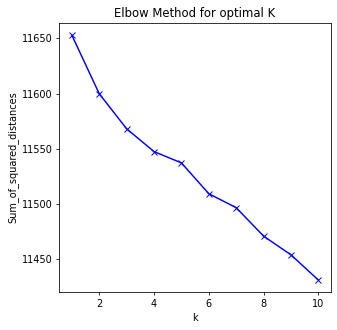

In [42]:
plt.style.use('default')
plt.figure(figsize = (5,5),dpi=70) 
plt.plot(K,Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method for optimal K')
plt.show()

In [43]:
km = cluster.KMeans(n_clusters=4, init='k-means++').fit(df_tv)#

In [44]:
km.cluster_centers_

array([[ 5.13938023e-04,  3.64881416e-04,  5.52022950e-04, ...,
         6.72708749e-04,  6.09770021e-04,  3.98155446e-04],
       [ 1.29221266e-03, -1.08420217e-19, -3.25260652e-19, ...,
         1.08420217e-19,  1.26667237e-03,  1.08955429e-03],
       [ 4.41578633e-04,  3.12089750e-04,  4.68760500e-04, ...,
         5.83414975e-04,  9.73946409e-04, -1.02999206e-18],
       [ 0.00000000e+00,  0.00000000e+00,  2.42859861e-03, ...,
         4.33680869e-19,  1.20371706e-03,  2.71050543e-19]])

In [45]:
df_tv['kmeans_cluster'] = km.labels_
df_tv['kmeans_cluster'].value_counts()

0    9931
2    1104
3     381
1     308
Name: kmeans_cluster, dtype: int64

In [46]:
lda0=extractclusterlda(df_tv,'kmeans_cluster',0)
lda1=extractclusterlda(df_tv,'kmeans_cluster',1)
lda2=extractclusterlda(df_tv,'kmeans_cluster',2)
lda3=extractclusterlda(df_tv,'kmeans_cluster',3)
#lda4=extractclusterlda(df_tv,'kmeans_cluster',4)
#lda5=extractclusterlda(df_tv,'kmeans_cluster',5)
models=[lda0,lda1,lda2,lda3]#,lda4,lda5
topics=['Topic Clust 0','Topic Clust 1','Topic Clust 2','Topic Clust 3']#,'Topic Clust 4','Topic Clust 5'
for model,topic in zip(models,topics):
    print(print_main_topic(model,tf_feature_names,n_top_words,topic))

Topic Clust 0: leak, always, reid, ceiling, senate candidate, employee, los angele, firm, increasingly, august
Topic Clust 1: israel, ivory, standoff, farm, rupaul drag, create, authority, kristen wiig, huffpost rise, epidemic
Topic Clust 2: ivory, insane, rush, incident, innocent, increasingly, like pro, intend, playoff, firm
Topic Clust 3: standoff, ivory, rush, epidemic, mood, star, playoff, jerry, horror story, increasingly


In [47]:
df_tv=df_tv.drop(['kmeans_cluster'],axis=1)

In [48]:
tf_feature_names = tv.get_feature_names()
n_top_words = 10
n_components = 4
lda = LatentDirichletAllocation(n_components=n_components, max_iter=10,
                                learning_method = 'batch',
                                n_jobs=-1)#,verbose=1
lda.fit(df_tv)
print(print_top_words(lda, tf_feature_names, n_top_words))

Topic 0: man, woman, study, dead, child, make, people, reveal, nation, american
Topic 1: man, like, local, parent, couple, die, back, good, dad, release
Topic 2: man, woman, nation, trump, make, obama, state, room, name, tell
Topic 3: man, american, bush, dog, work, clinton, long, no, nation, really

None


In [49]:
tf_feature_names = tv.get_feature_names()
n_top_words = 10
n_components = 1
lda = LatentDirichletAllocation(n_components=n_components, max_iter=10,
                                learning_method = 'batch',
                                n_jobs=-1)#,verbose=1
lda.fit(df_tv)
print(print_main_topic(lda, tf_feature_names, n_top_words,'General topic'))

General topic: man, woman, nation, make, american, study, like, good, child, family


## Split and TF-IDF Vectorizer for supervised task

In [50]:
label = df2.pop('is_sarcastic')

In [51]:
X_train, X_test, y_train, y_test = train_test_split(df2, label, stratify=label, test_size=0.2, random_state=42)

In [52]:
X_train.shape, X_test.shape

((21367, 11), (5342, 11))

In [53]:
Counter(y_train), Counter(y_test)

(Counter({1: 9379, 0: 11988}), Counter({0: 2997, 1: 2345}))

In the Markdown (code) below I tried to bootstrap part of the training set in order to extract those istance with a certain level of 'compound' polarity (had also to reduce 'test_size' during split to take in account the reduction in training size), to look if it could possibly improve my classification, however, not only classification results got worse but also led to overfitting

#Selecting just a sample of the Training set with 'compound'>0, sampling y_train also
y_train=y_train.to_frame()
y_train['compound'] =X_train['compound']
X_train = X_train[X_train['compound'] > -0.1]
y_train = y_train[y_train['compound'] > -0.1]
y_train=y_train.drop(['compound'],axis=1)
y_train=y_train.squeeze()

In [54]:
#Applying tf-idf on train,test for supervised task

In [55]:
tvtt = TfidfVectorizer(min_df=3,ngram_range=(1,2),use_idf=True)#max_df=0.90,,stop_words=stopwords,min_df=3

X_traintv = tvtt.fit_transform(X_train['clean_headline']).toarray()
X_traintv = pd.DataFrame(X_traintv, columns=tvtt.get_feature_names())

X_testtv = tvtt.transform(X_test['clean_headline']).toarray()
X_testtv = pd.DataFrame(X_testtv, columns=tvtt.get_feature_names())

In [56]:
print(X_traintv.shape)
print(X_testtv.shape)

(21367, 10599)
(5342, 10599)


## Feature Selection for supervised task

In [57]:
#It takes quite some time
selected_features = SelectKBest(chi2, k=4000).fit(X_traintv, y_train)
X_train_bestfeat = selected_features.transform(X_traintv)
X_test_bestfeat = selected_features.transform(X_testtv)

In [58]:
print(X_train_bestfeat.shape)
X_test_bestfeat.shape

(21367, 4000)


(5342, 4000)

In [59]:
# Get columns to keep and create new dataframe with those only
cols = selected_features.get_support(indices=True)
X_train_bestfeat = X_traintv.iloc[:,cols]
X_test_bestfeat=X_testtv.iloc[:,cols]

In [60]:
X_train_bestfeat.shape

(21367, 4000)

In [61]:
X_test_bestfeat.shape

(5342, 4000)

## Join for Classification dataset

In [62]:
X_train=X_train.drop(['headline','clean_headline'],axis=1).reset_index(drop=True)
X_test=X_test.drop(['headline','clean_headline'],axis=1).reset_index(drop=True)

In [63]:
#Apparently there is a column from the tdidf df whose name is 'compound', we re changing the name on X_train/X_test before join
X_train.rename(columns = {'compound':'compoundVader'}, inplace = True)
X_test.rename(columns = {'compound':'compoundVader'}, inplace = True)

X_train_data=X_train.join(X_train_bestfeat)

X_test_data=X_test.join(X_test_bestfeat)

In [64]:
X_train_data=X_train.join(X_train_bestfeat.set_index(X_train.index[:len(X_train_bestfeat)]))

In [65]:
X_test_data=X_test.join(X_test_bestfeat.set_index(X_test.index[:len(X_test_bestfeat)]))

In [66]:
print(X_train_data.shape)
print(X_test_data.shape)

(21367, 4009)
(5342, 4009)


# Model Training and Evaluation

## Logistic Regression

In [67]:
params = {'C': np.logspace(-3,3,7),
          'solver': ['liblinear'],
         }
cv=RepeatedStratifiedKFold(n_splits=4, n_repeats=2, random_state=1)

In [68]:
lr = LogisticRegression()
lrrs = RandomizedSearchCV(lr, params, 
                            n_iter=4,random_state=126,scoring='accuracy',n_jobs=-1,  
                            cv=cv,verbose=3).fit(X_train_data, y_train)
print('\nThe best model selected is:\n{}'.format(lrrs.best_estimator_))
report_cv(lrrs.cv_results_)

Fitting 8 folds for each of 4 candidates, totalling 32 fits

The best model selected is:
LogisticRegression(C=10.0, solver='liblinear')
Mean validation score: 0.83800 (std: 0.00472)
Parameters: {'solver': 'liblinear', 'C': 10.0}

Mean validation score: 0.83718 (std: 0.00346)
Parameters: {'solver': 'liblinear', 'C': 100.0}

Mean validation score: 0.81521 (std: 0.00620)
Parameters: {'solver': 'liblinear', 'C': 1.0}

Mean validation score: 0.60792 (std: 0.00424)
Parameters: {'solver': 'liblinear', 'C': 0.001}



In [69]:
lr=LogisticRegression(**lrrs.best_params_).fit(X_train_data, y_train)

In [70]:
y_pred_tr = lr.predict(X_train_data)

print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average=None))

print(classification_report(y_train, y_pred_tr))
pd.DataFrame(confusion_matrix(y_train, y_pred_tr),
             index = ['class 0 actual', 'class 1 actual'],
             columns = ['class 0 pred', 'class 1 pred'])

Train Accuracy 0.8884260775962933
Train F1-score [0.90232711 0.8699116 ]
              precision    recall  f1-score   support

           0       0.89      0.92      0.90     11988
           1       0.89      0.85      0.87      9379

    accuracy                           0.89     21367
   macro avg       0.89      0.88      0.89     21367
weighted avg       0.89      0.89      0.89     21367



,class 0 pred,class 1 pred
class 0 actual,11012,976
class 1 actual,1408,7971


In [71]:
y_predlr = lr.predict(X_test_data)
print('Test Accuracy %s' % accuracy_score(y_test, y_predlr))
print('Test F1-score %s' % f1_score(y_test, y_predlr, average=None))

print(classification_report(y_test, y_predlr))
pd.DataFrame(confusion_matrix(y_test, y_predlr),
             index = ['class 0 actual', 'class 1 actual'],
             columns = ['class 0 pred', 'class 1 pred'])

Test Accuracy 0.8114938225383751
Test F1-score [0.83569914 0.77892426]
              precision    recall  f1-score   support

           0       0.82      0.85      0.84      2997
           1       0.80      0.76      0.78      2345

    accuracy                           0.81      5342
   macro avg       0.81      0.81      0.81      5342
weighted avg       0.81      0.81      0.81      5342



,class 0 pred,class 1 pred
class 0 actual,2561,436
class 1 actual,571,1774


In [72]:
yproblrpre = lr.predict_proba(X_test_data)[:,1]
print("AUC:", round(roc_auc_score(y_test, yproblrpre),2))

AUC: 0.89


## Decision Tree

In [73]:
params={'max_depth': [x for x in range(2,15)],
        'criterion': ['gini', 'entropy']}
cv=RepeatedStratifiedKFold(n_splits=4, n_repeats=2, random_state=1)    

In [74]:
dt = DecisionTreeClassifier()
dtrs = RandomizedSearchCV(dt, params, 
                         n_iter=4,random_state=126,scoring='accuracy',n_jobs=-1,  
                         cv=cv,verbose=3).fit(X_train_data, y_train)
print('\nThe best model selected is:\n{}'.format(dtrs.best_estimator_))
report_cv(dtrs.cv_results_)

Fitting 8 folds for each of 4 candidates, totalling 32 fits

The best model selected is:
DecisionTreeClassifier(max_depth=14)
Mean validation score: 0.68500 (std: 0.00783)
Parameters: {'max_depth': 14, 'criterion': 'gini'}

Mean validation score: 0.67810 (std: 0.00472)
Parameters: {'max_depth': 11, 'criterion': 'entropy'}

Mean validation score: 0.67031 (std: 0.00444)
Parameters: {'max_depth': 7, 'criterion': 'gini'}

Mean validation score: 0.66954 (std: 0.00747)
Parameters: {'max_depth': 8, 'criterion': 'entropy'}



In [75]:
type(dtrs)

sklearn.model_selection._search.RandomizedSearchCV

In [76]:
dt=DecisionTreeClassifier(**dtrs.best_params_).fit(X_train_data, y_train)

In [77]:
y_pred_tr = dt.predict(X_train_data)

print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average=None))

print(classification_report(y_train, y_pred_tr))
pd.DataFrame(confusion_matrix(y_train, y_pred_tr),
             index = ['class 0 actual', 'class 1 actual'],
             columns = ['class 0 pred', 'class 1 pred'])

Train Accuracy 0.7505499134178873
Train F1-score [0.79597305 0.67910897]
              precision    recall  f1-score   support

           0       0.74      0.87      0.80     11988
           1       0.78      0.60      0.68      9379

    accuracy                           0.75     21367
   macro avg       0.76      0.73      0.74     21367
weighted avg       0.76      0.75      0.74     21367



,class 0 pred,class 1 pred
class 0 actual,10397,1591
class 1 actual,3739,5640


In [78]:
y_preddt = dt.predict(X_test_data)
print('Test Accuracy %s' % accuracy_score(y_test, y_preddt))
print('Test F1-score %s' % f1_score(y_test, y_preddt, average=None))

print(classification_report(y_test, y_preddt))
pd.DataFrame(confusion_matrix(y_test, y_preddt),
             index = ['class 0 actual', 'class 1 actual'],
             columns = ['class 0 pred', 'class 1 pred'])

Test Accuracy 0.6830774990640209
Test F1-score [0.74037724 0.59332212]
              precision    recall  f1-score   support

           0       0.69      0.81      0.74      2997
           1       0.68      0.53      0.59      2345

    accuracy                           0.68      5342
   macro avg       0.68      0.67      0.67      5342
weighted avg       0.68      0.68      0.68      5342



,class 0 pred,class 1 pred
class 0 actual,2414,583
class 1 actual,1110,1235


In [79]:
yprobdtpre = dt.predict_proba(X_test_data)[:,1]
print("AUC:", round(roc_auc_score(y_test, yprobdtpre),2))

AUC: 0.73


## Random Forest Classifier

In [80]:
params = {'max_depth': [x for x in range(2,10)],
              'n_estimators': [x for x in range(2,20)]
              }

In [81]:
rf = RandomForestClassifier()
rfrs = RandomizedSearchCV(rf, params, 
                            n_iter=4,random_state=126,scoring='accuracy',n_jobs=-1,  
                            cv=cv,verbose=3).fit(X_train_data, y_train)
print('\nThe best model selected is:\n{}'.format(rfrs.best_estimator_))
report_cv(rfrs.cv_results_)

Fitting 8 folds for each of 4 candidates, totalling 32 fits

The best model selected is:
RandomForestClassifier(max_depth=8, n_estimators=10)
Mean validation score: 0.62402 (std: 0.01112)
Parameters: {'n_estimators': 10, 'max_depth': 8}

Mean validation score: 0.62051 (std: 0.01513)
Parameters: {'n_estimators': 5, 'max_depth': 7}

Mean validation score: 0.58703 (std: 0.00818)
Parameters: {'n_estimators': 13, 'max_depth': 4}

Mean validation score: 0.57025 (std: 0.00561)
Parameters: {'n_estimators': 10, 'max_depth': 2}



In [82]:
rf=RandomForestClassifier(**rfrs.best_params_).fit(X_train_data, y_train)

In [83]:
y_pred_tr = rf.predict(X_train_data)

print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average=None))

print(classification_report(y_train, y_pred_tr))
pd.DataFrame(confusion_matrix(y_train, y_pred_tr),
             index = ['class 0 actual', 'class 1 actual'],
             columns = ['class 0 pred', 'class 1 pred'])

Train Accuracy 0.6256376655590397
Train F1-score [0.74843539 0.26862942]
              precision    recall  f1-score   support

           0       0.60      0.99      0.75     11988
           1       0.94      0.16      0.27      9379

    accuracy                           0.63     21367
   macro avg       0.77      0.57      0.51     21367
weighted avg       0.75      0.63      0.54     21367



,class 0 pred,class 1 pred
class 0 actual,11899,89
class 1 actual,7910,1469


In [84]:
y_predrf = rf.predict(X_test_data)
print('Test Accuracy %s' % accuracy_score(y_test, y_predrf))
print('Test F1-score %s' % f1_score(y_test, y_predrf, average=None))

print(classification_report(y_test, y_predrf))
pd.DataFrame(confusion_matrix(y_test, y_predrf),
             index = ['class 0 actual', 'class 1 actual'],
             columns = ['class 0 pred', 'class 1 pred'])

Test Accuracy 0.6194309247472857
Test F1-score [0.74469421 0.25284822]
              precision    recall  f1-score   support

           0       0.60      0.99      0.74      2997
           1       0.91      0.15      0.25      2345

    accuracy                           0.62      5342
   macro avg       0.76      0.57      0.50      5342
weighted avg       0.74      0.62      0.53      5342



,class 0 pred,class 1 pred
class 0 actual,2965,32
class 1 actual,2001,344


In [85]:
yprobrfpre = rf.predict_proba(X_test_data)[:,1]
print("AUC:", round(roc_auc_score(y_test, yprobrfpre),2))

AUC: 0.75


## XGBoost

In [86]:
scale_pos_weight=round(sum(y_train.to_frame().is_sarcastic==0)/sum(y_train.to_frame().is_sarcastic==1),1)
params = {
              'colsample_bytree' : [0.3, 0.5, 0.9],
              'colsample_bylevel' : [0.3, 0.5, 0.9],
              'max_depth': [3, 5, 7], 
              'n_estimators' : [100, 200],
             }

In [87]:
xgb = XGBClassifier(objective =  'binary:logistic', scale_pos_weight = scale_pos_weight,learning_rate = 0.1, seed=1234)

In [88]:
xgbrs = RandomizedSearchCV(xgb, params, 
                            n_iter=4,random_state=126,scoring='accuracy',n_jobs=-1,  
                            cv=cv,verbose=3).fit(X_train_data, y_train)
print('\nThe best model selected is:\n{}'.format(xgbrs.best_estimator_))
report_cv(xgbrs.cv_results_)

Fitting 8 folds for each of 4 candidates, totalling 32 fits

The best model selected is:
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.3, colsample_bynode=1, colsample_bytree=0.9,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=1234, reg_alpha=0, reg_lambda=1, ...)
Mean validation score: 0.74837 (std: 0.00684)
Parameters: {'n_estimators': 200, 'max_depth': 5, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.3}

Mean validation score: 0.73141 (std: 0.00553)
Parameters: {'n_est

In [89]:
xgb=XGBClassifier(**xgbrs.best_params_).fit(X_train_data, y_train)

In [90]:
y_pred_tr = xgb.predict(X_train_data)

print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average=None))

print(classification_report(y_train, y_pred_tr))
pd.DataFrame(confusion_matrix(y_train, y_pred_tr),
             index = ['class 0 actual', 'class 1 actual'],
             columns = ['class 0 pred', 'class 1 pred'])

Train Accuracy 0.8335283380914494
Train F1-score [0.85821342 0.79843599]
              precision    recall  f1-score   support

           0       0.82      0.90      0.86     11988
           1       0.85      0.75      0.80      9379

    accuracy                           0.83     21367
   macro avg       0.84      0.82      0.83     21367
weighted avg       0.84      0.83      0.83     21367



,class 0 pred,class 1 pred
class 0 actual,10765,1223
class 1 actual,2334,7045


In [91]:
y_predxgb = xgb.predict(X_test_data)
print('Test Accuracy %s' % accuracy_score(y_test, y_predxgb))
print('Test F1-score %s' % f1_score(y_test, y_predxgb, average=None))

print(classification_report(y_test, y_predxgb))
pd.DataFrame(confusion_matrix(y_test, y_predxgb),
             index = ['class 0 actual', 'class 1 actual'],
             columns = ['class 0 pred', 'class 1 pred'])

Test Accuracy 0.7764882066641707
Test F1-score [0.81113572 0.72627235]
              precision    recall  f1-score   support

           0       0.77      0.86      0.81      2997
           1       0.79      0.68      0.73      2345

    accuracy                           0.78      5342
   macro avg       0.78      0.77      0.77      5342
weighted avg       0.78      0.78      0.77      5342



,class 0 pred,class 1 pred
class 0 actual,2564,433
class 1 actual,761,1584


In [92]:
yprobxgbpre = xgb.predict_proba(X_test_data)[:,1]
print("AUC:", round(roc_auc_score(y_test, yprobxgbpre),2))

AUC: 0.86


## Support Vector Machine (mission aborted... too much time needed,do not run)

params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
          'gamma' : ['scale'],
          'C'     : [0.001, 0.01, 0.1, 0.5, 1]}
cv=RepeatedStratifiedKFold(n_splits=4, n_repeats=2, random_state=1)          

svm = SVC()
svmrs = RandomizedSearchCV(svm, params, 
                            n_iter=4,random_state=126,scoring='accuracy',n_jobs=-1,  
                            cv=cv,verbose=3).fit(X_train_data, y_train)
print('\nThe best model selected is:\n{}'.format(svmrs.best_estimator_))
report_cv(svmrs.cv_results_)

svm=SVC(**svmrs.best_params_).fit(X_train_data, y_train)

y_pred_tr = svm.predict(X_train_data)

print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average=None))

print(classification_report(y_train, y_pred_tr))
pd.DataFrame(confusion_matrix(y_train, y_pred_tr),
             index = ['class 0 actual', 'class 1 actual'],
             columns = ['class 0 pred', 'class 1 pred'])

y_predsvm = svm.predict(X_test_data)
print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
print('Test F1-score %s' % f1_score(y_test, y_pred, average=None))

print(classification_report(y_test, y_pred))
pd.DataFrame(confusion_matrix(y_test, y_pred),
             index = ['class 0 actual', 'class 1 actual'],
             columns = ['class 0 pred', 'class 1 pred'])

yprobsvmpre = svm.predict_proba(X_test_data)[:,1]
print("AUC:", round(roc_auc_score(y_test, yprobsvmpre),2))

## Models Recap

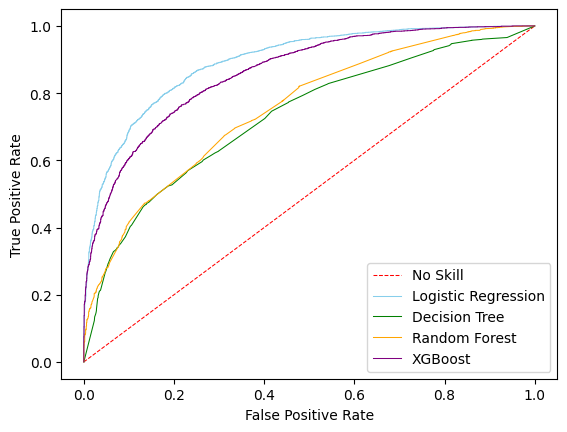

In [93]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
y_probs = [yproblrpre,yprobdtpre,yprobrfpre,yprobxgbpre]  
# inserire i nomi in ordine rispetto ai predict_proba inseriti
get_roc_curve_plot_new(y_test, y_probs, legend_model=['Logistic Regression','Decision Tree','Random Forest','XGBoost'], multiple=True)

In [94]:
recap_perf_clf = pd.concat([get_metrics_clf(y_test, yproblrpre, th = 0.5, name_col = 'LogisticRegression'),
                            get_metrics_clf(y_test, yprobdtpre, th = 0.5, name_col = 'Decision Tree'),
                            get_metrics_clf(y_test, yprobrfpre, th = 0.5, name_col = 'Random Forest'),
                            get_metrics_clf(y_test, yprobxgbpre, th = 0.5, name_col = 'XGBoost'),
                            ], 
                           axis = 1).T
recap_perf_clf

,Threshold,Precision,Recall,F1,Accuracy,AUC
LogisticRegression,0.5,0.818,0.855,0.836,0.811,0.893
Decision Tree,0.5,0.685,0.805,0.740,0.683,0.729
Random Forest,0.5,0.597,0.989,0.745,0.619,0.753
XGBoost,0.5,0.771,0.856,0.811,0.776,0.861


## Explainability

## Decision Tree

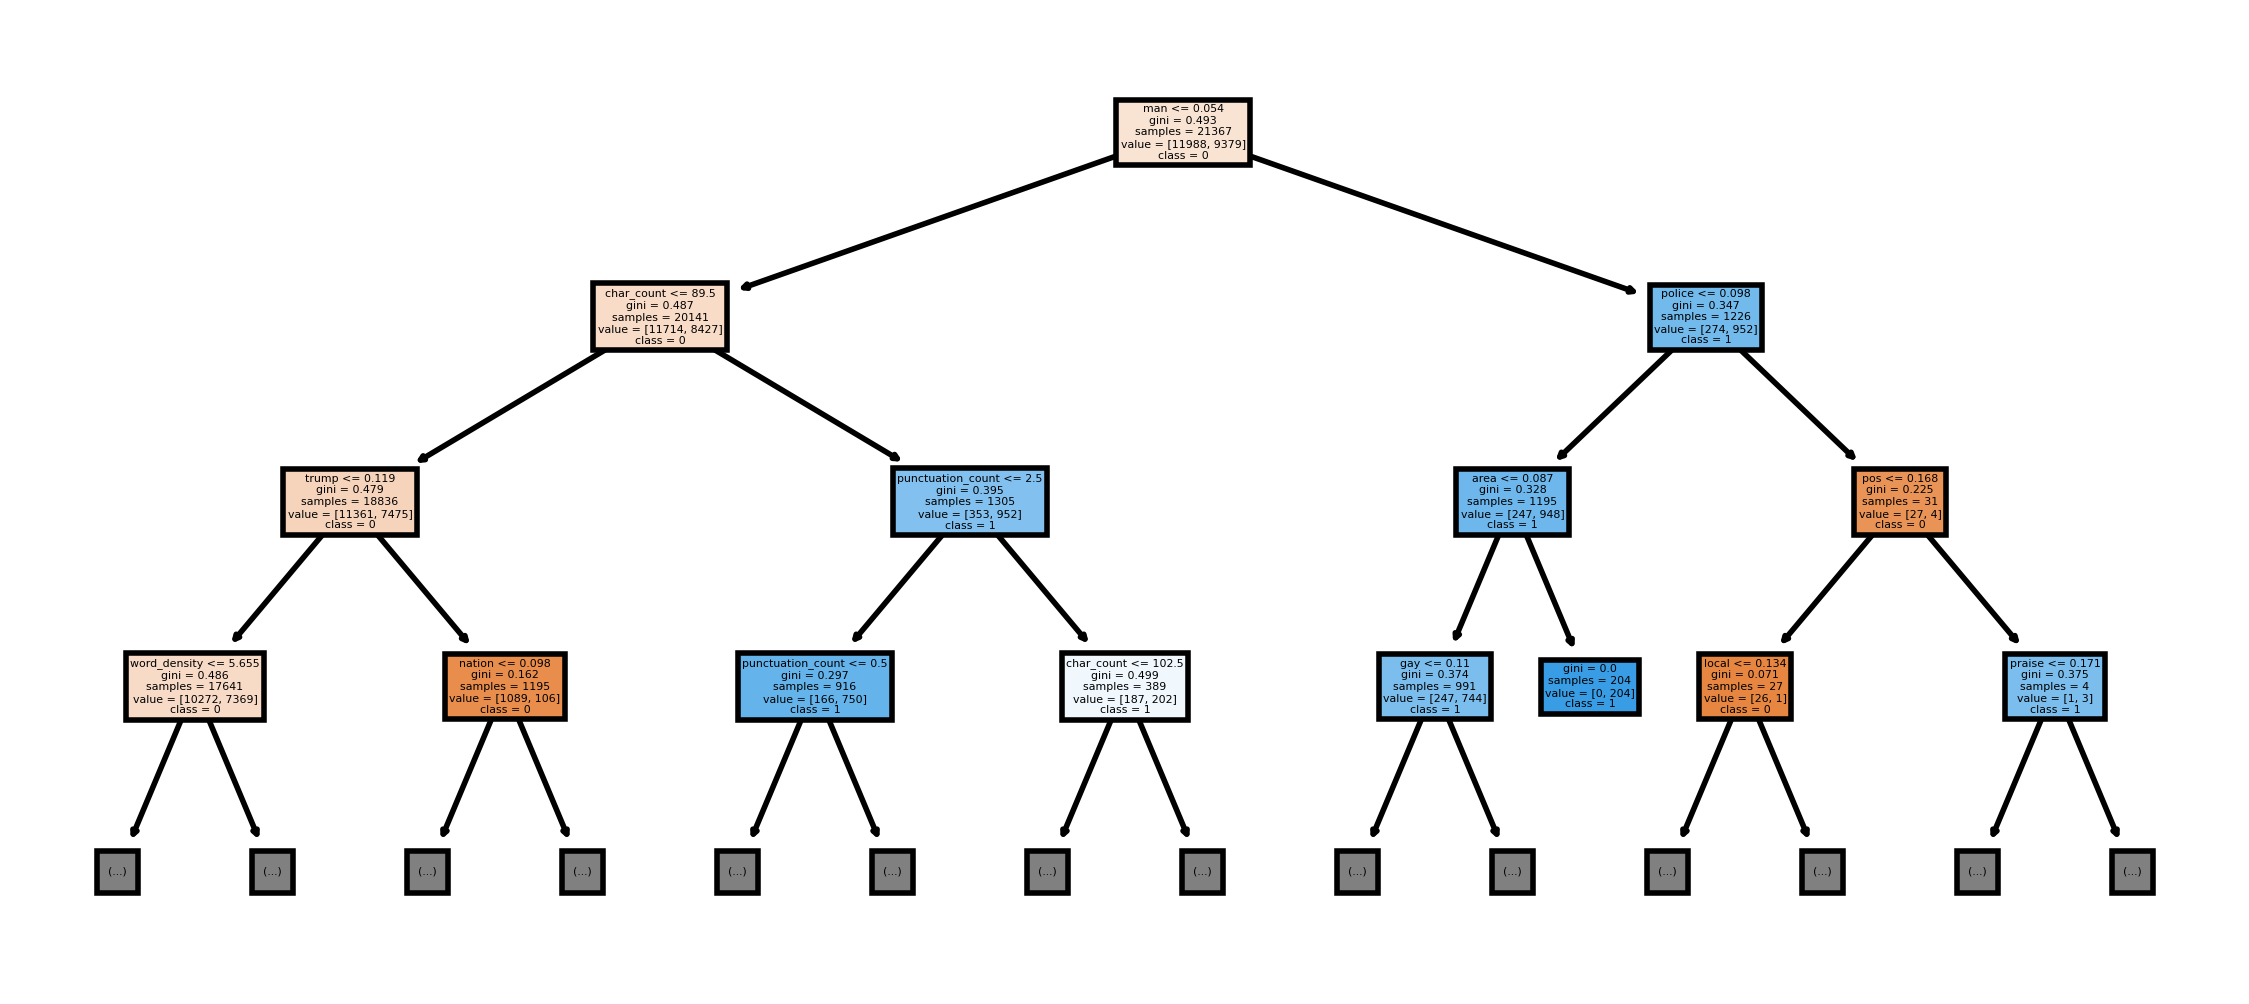

In [95]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (7,3), dpi=400)
tree.plot_tree(dt,
               feature_names = list(X_train_data.columns), 
               class_names=['0','1'],
               max_depth=3,
               filled = True);

## TREPAN on Logistic Regression

In [96]:
y_pred_train=lr.predict(X_train_data)

In [97]:
explainer= DecisionTreeClassifier(max_depth=20).fit(X_train_data,y_pred_train)

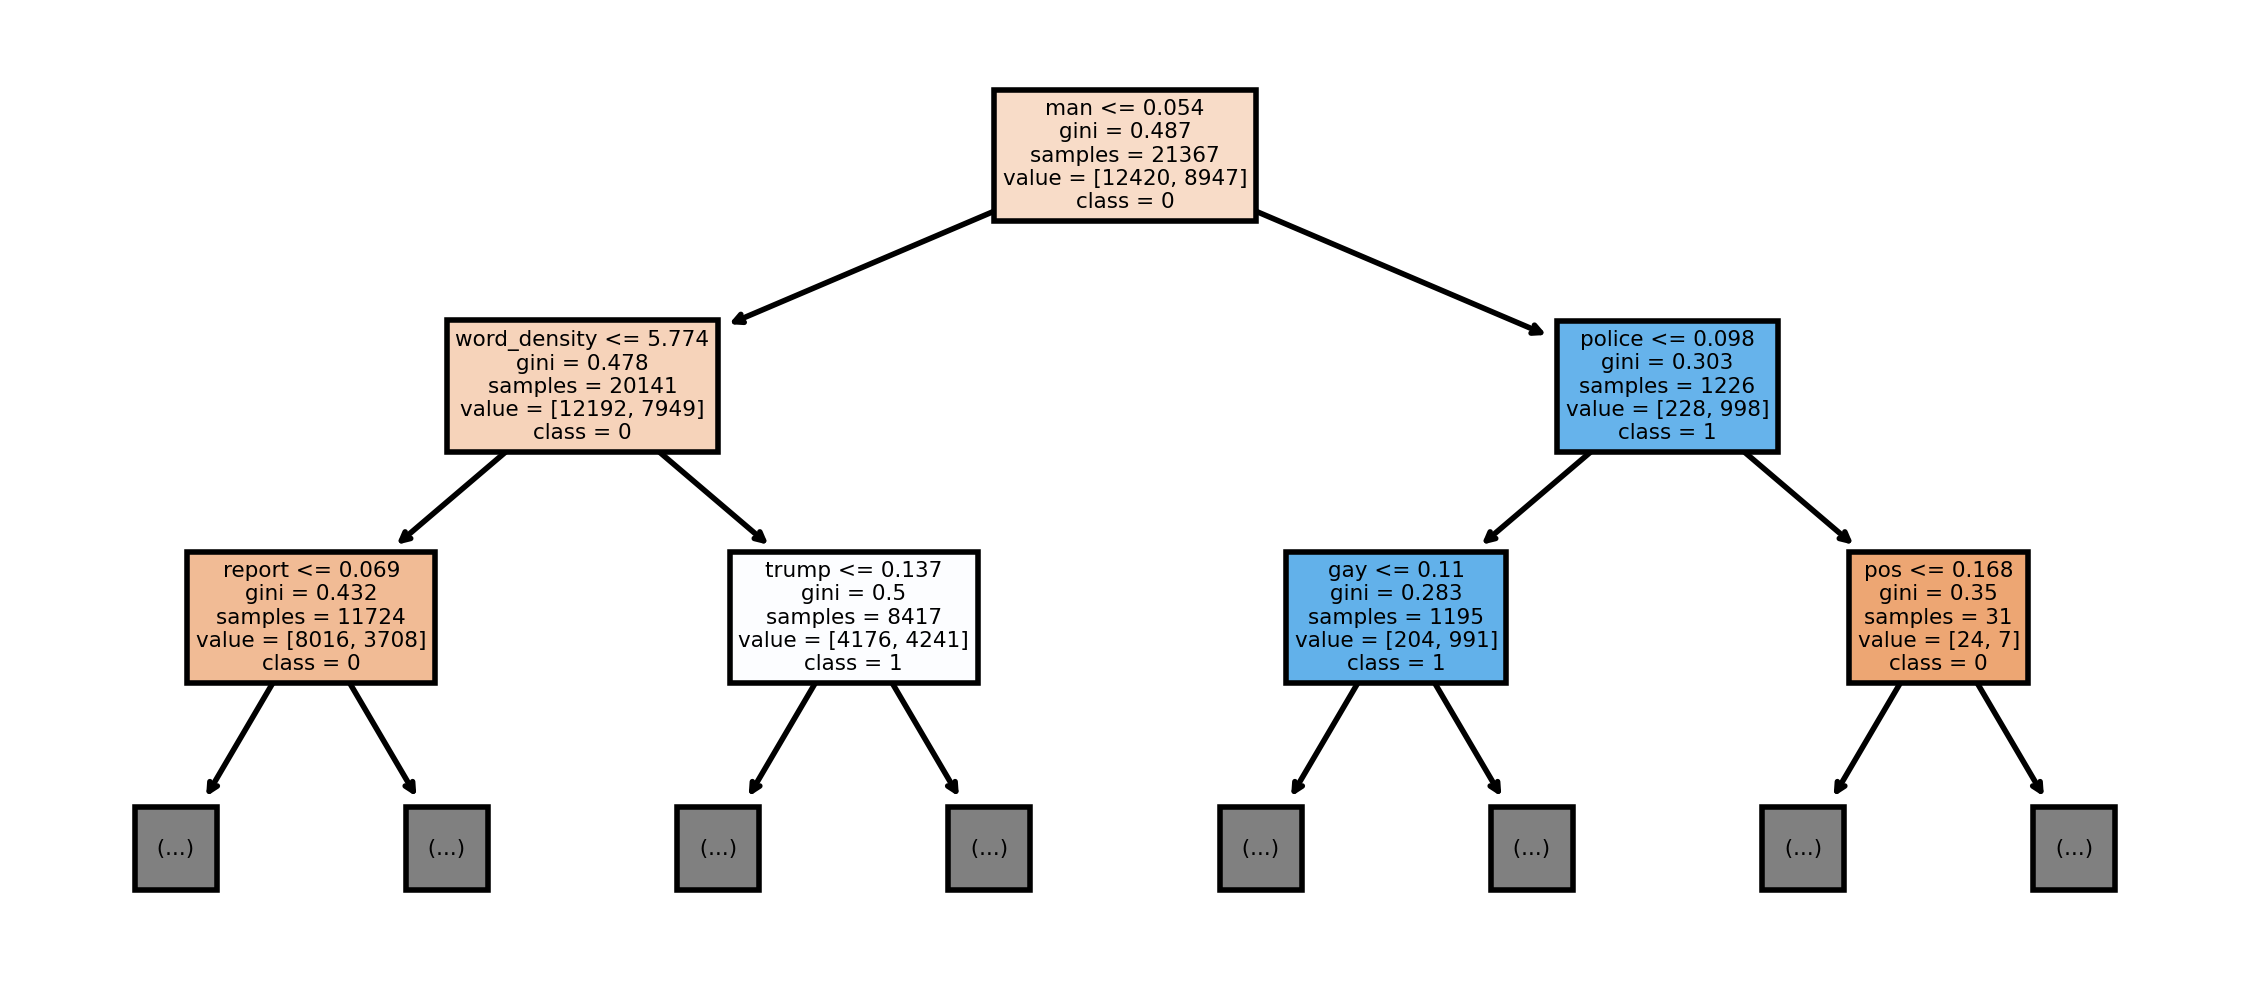

In [98]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (7,3), dpi=400)
tree.plot_tree(explainer,
               feature_names = list(X_train_data.columns), 
               class_names=['0','1'],
               max_depth=2,
               filled = True);

In [99]:
ypredlr2=lr.predict(X_test_data)
accuracy_score(ypredlr2, explainer.predict(X_test_data))

0.7223886184949457

### Random Forest Feature importance

In [100]:
print_feature_importances_random_forest(rf)

word_density -> 0.1091
trump -> 0.0985
man -> 0.0679
area -> 0.0585
donald -> 0.0432
punctuation_count -> 0.0422
coworker -> 0.0346
local -> 0.0305
char_count -> 0.0299
introduce -> 0.0207
around -> 0.0184
report -> 0.0182
area woman -> 0.0142
little -> 0.0141
guy -> 0.0139
study -> 0.0134
Subjectivity -> 0.0126
force -> 0.0122
report american -> 0.0116
republican -> 0.0113
go -> 0.0111
fuck -> 0.0107
unveil -> 0.0106
deal -> 0.0105
black -> 0.0098
god -> 0.0097
clearly -> 0.0097
bernie sander -> 0.0089
self -> 0.0082
tweet -> 0.0082
abuse -> 0.0082
friend -> 0.0072
party -> 0.0072
america -> 0.0067
spend -> 0.0064
hillary clinton -> 0.0064
apartment -> 0.0062
announce -> 0.0061
democrat -> 0.0061
fucking -> 0.0058
compoundVader -> 0.0057
hour -> 0.0056
california -> 0.0054
health -> 0.0053
year -> 0.0048
accuse -> 0.0046
eye -> 0.0046
majority -> 0.0041
purchase -> 0.0041
shit -> 0.0040
need -> 0.0039
not wait -> 0.0038
unable -> 0.0038
race -> 0.0035
admit -> 0.0031
sure -> 0.0029
fi

discover -> 0.0000
discover new -> 0.0000
discrimination -> 0.0000
discussion -> 0.0000
disgruntle -> 0.0000
disgusting -> 0.0000
dishwasher -> 0.0000
disick -> 0.0000
disillusion -> 0.0000
display -> 0.0000
disruption -> 0.0000
divide -> 0.0000
divine -> 0.0000
division -> 0.0000
diy -> 0.0000
dj -> 0.0000
doctor -> 0.0000
dodger -> 0.0000
doggy -> 0.0000
dolby -> 0.0000
dolby theatre -> 0.0000
dole -> 0.0000
doll -> 0.0000
dolled -> 0.0000
domestic -> 0.0000
domestic violence -> 0.0000
domino -> 0.0000
donald trump -> 0.0000
doorstep -> 0.0000
doorway -> 0.0000
dope -> 0.0000
dorito -> 0.0000
dorm -> 0.0000
dot -> 0.0000
doug -> 0.0000
download -> 0.0000
dr -> 0.0000
drag queen -> 0.0000
drag race -> 0.0000
drake -> 0.0000
drawer -> 0.0000
dread -> 0.0000
dream come -> 0.0000
dream one -> 0.0000
dreamer -> 0.0000
driverless -> 0.0000
driverless car -> 0.0000
drone -> 0.0000
drone strike -> 0.0000
drug war -> 0.0000
drummer -> 0.0000
drunk -> 0.0000
drunkenly -> 0.0000
dry -> 0.0000
d

lure -> 0.0000
lynch -> 0.0000
machiavellian -> 0.0000
machine -> 0.0000
madness -> 0.0000
magazine -> 0.0000
magic -> 0.0000
maher -> 0.0000
mail -> 0.0000
main -> 0.0000
mainstream -> 0.0000
majority american -> 0.0000
make -> 0.0000
make decision -> 0.0000
make every -> 0.0000
make fun -> 0.0000
make hard -> 0.0000
make history -> 0.0000
make last -> 0.0000
make life -> 0.0000
make live -> 0.0000
make man -> 0.0000
make never -> 0.0000
make someone -> 0.0000
make stop -> 0.0000
make thing -> 0.0000
malia -> 0.0000
mall -> 0.0000
mama -> 0.0000
man accuse -> 0.0000
man allegedly -> 0.0000
man always -> 0.0000
man bad -> 0.0000
man bar -> 0.0000
man begin -> 0.0000
man body -> 0.0000
man buy -> 0.0000
man could -> 0.0000
man die -> 0.0000
man eat -> 0.0000
man enjoy -> 0.0000
man excited -> 0.0000
man expect -> 0.0000
man feel -> 0.0000
man force -> 0.0000
man get -> 0.0000
man go -> 0.0000
man good -> 0.0000
man hate -> 0.0000
man hope -> 0.0000
man keep -> 0.0000
man know -> 0.0000


satisfied -> 0.0000
satisfy -> 0.0000
satisfy flavor -> 0.0000
saturday -> 0.0000
saturday night -> 0.0000
sauce -> 0.0000
saudi -> 0.0000
saudi arabia -> 0.0000
save life -> 0.0000
save live -> 0.0000
saving -> 0.0000
say love -> 0.0000
say man -> 0.0000
say nation -> 0.0000
say something -> 0.0000
say trump -> 0.0000
say white -> 0.0000
say would -> 0.0000
scam -> 0.0000
scan -> 0.0000
scaramucci -> 0.0000
school bully -> 0.0000
school student -> 0.0000
schooler -> 0.0000
schumer -> 0.0000
science -> 0.0000
scientist -> 0.0000
scientist discover -> 0.0000
scientist finally -> 0.0000
scientist say -> 0.0000
scientist warn -> 0.0000
scooter -> 0.0000
score -> 0.0000
scott -> 0.0000
scott disick -> 0.0000
scrabble -> 0.0000
scream -> 0.0000
script -> 0.0000
scroll -> 0.0000
sear -> 0.0000
season trailer -> 0.0000
seating -> 0.0000
seaworld -> 0.0000
second -> 0.0000
second grader -> 0.0000
secret -> 0.0000
secretary -> 0.0000
secretary agriculture -> 0.0000
secretary education -> 0.0000

## SHAP on XGBoost

In [101]:
from shap import TreeExplainer

In [102]:
explainerxgb=TreeExplainer(xgb)

In [103]:
shap_valuesxgb = explainerxgb(X_test_data)

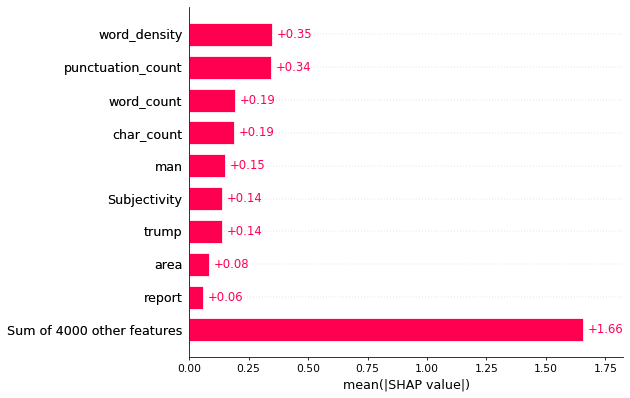

In [104]:
plt.figure(figsize = (5,5),dpi=70)
shap.plots.bar(shap_valuesxgb)

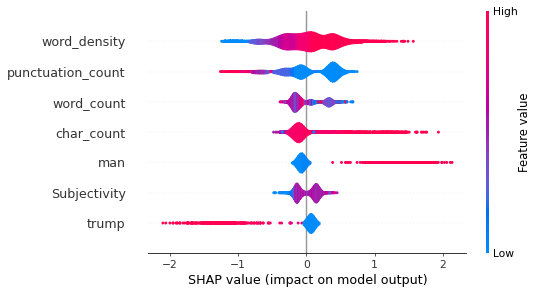

In [105]:
plt.figure(figsize = (5,5),dpi=70)
shap.summary_plot(shap_valuesxgb,X_test_data, plot_type='violin', max_display=7)